## Intro

This is an example notebook of my workflow in image classification using conventional pattern recognition methods such as texture metrics instead of neural networks. While neural nets can have high accuracy and find similarities in images without human interaction, using conventional features can provide better explainability, work better with smaller datasets, be computationally less demanding and are more robust to a limited dataset.

**Purpose:** showcase pattern recognition skills with conventional methods and interest in image manipulation.

**Inputs:**  
- 172 images of lava, ocean and trees, about 1/3 of each.

In [199]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os
from tqdm import tqdm

from skimage.io import imread, imsave # For reading image
from skimage.transform import rescale
from skimage import color # For turning image into greyscale
from skimage import img_as_ubyte # For changing image type
from scipy.stats import kurtosis, skew
from skimage.feature import graycomatrix, graycoprops

from sklearn.decomposition import PCA # for PCA
from scipy.stats import zscore # For standardization

from sklearn.model_selection import KFold # for folds
from sklearn.model_selection import LeaveOneOut # for folds

from sklearn.metrics import accuracy_score # for the accuracy score
from sklearn.metrics import confusion_matrix # For confusion matrix

import lightgbm as lgb

In [1]:
# Use Bing to automatically download images
#from bing_image_downloader import downloader
#downloader.download("ocean", limit=30,  output_dir='images', 
#adult_filter_off=True, force_replace=False, timeout=60)

In [9]:
PATH = "data/04 - Image Classification/ocean"
i = 31
for f in os.listdir(PATH):
    if ((f.split(".")[-1]=="png") or (f.split(".")[-1]=="gif")):
        continue
    PATH_full = os.path.join(PATH,f)
    img = imread(PATH_full)
    newname = f"Image_{i}.jpg"
    PATH_new = os.path.join(PATH,newname)
    imsave(PATH_new, img)
    i+=1

In [10]:
# Function for resizing and cropping the image. Inputs are the image and the new size.

def crop_resize(img, new=128):
    
    # Choose the shorter side
    smaller = img.shape[0] if img.shape[0]<img.shape[1] else img.shape[1]

    # Rescale the image to proper ratio (new size to shorter side)
    img_scl = rescale(img, new/smaller, anti_aliasing=True, channel_axis=2)
    
    # The remaining part to be cropped
    # Crop either x-axis or y-axis
    if img.shape[0]<img.shape[1]:
        edge = (img_scl.shape[1]-new)//2
        img_crp = img_scl[0:new,edge:new+edge]
    else:
        edge = (img_scl.shape[0]-new)//2
        img_crp = img_scl[edge:new+edge,0:new]
        
    return img_crp

In [11]:
# Scale all images in these folders to 256x256 if the images don't have "_scaled" in their names
PATH_lava = "data/04 - Image Classification/lava"
PATH_ocean = "data/04 - Image Classification/ocean"
PATH_trees = "data/04 - Image Classification/trees"

for PATH in [PATH_lava, PATH_ocean, PATH_trees]:
    files = os.listdir(PATH)
    files = [x for x in files if "scaled" not in x]
    for file in tqdm(files):
        PATH_full = os.path.join(PATH,file)
        img = imread(PATH_full)
        img = crop_resize(img,256)
        PATH_full_scaled = PATH_full.replace(".","_scaled.")
        img = (img * 255).astype(np.uint8)
        imsave(PATH_full_scaled, img)

100%|██████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.38it/s]


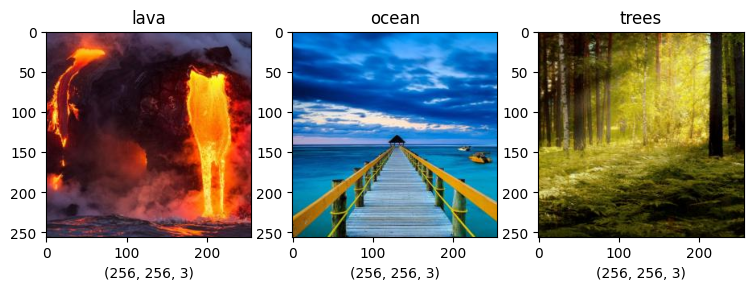

In [12]:
# Display the first image of each category and their dimensions
PATH_lava = "data/04 - Image Classification/lava"
PATH_ocean = "data/04 - Image Classification/ocean"
PATH_trees = "data/04 - Image Classification/trees"

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,4))
for i, PATH in enumerate([PATH_lava, PATH_ocean, PATH_trees]):
    PATH_firstimg = os.path.join(PATH, os.listdir(PATH)[0])
    img = imread(PATH_firstimg)
    ax[i].imshow(img)
    ax[i].set_xlabel(img.shape)
    ax[i].set_title(PATH.split("/")[-1])

In [13]:
%%time 

# Load all images into separate lists

IMGS_lava = []
IMGS_ocean = []
IMGS_trees = []
IMGS_list = [IMGS_lava,IMGS_ocean,IMGS_trees]

for i, PATH in enumerate([PATH_lava, PATH_ocean, PATH_trees]):
    files = os.listdir(PATH)
    for file in tqdm(files):
        PATH_firstimg = os.path.join(PATH, file)
        img = imread(PATH_firstimg)
        IMGS_list[i].append(img)

100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 395.04it/s]

CPU times: total: 109 ms
Wall time: 442 ms


# Main idea

The idea is for each image calculate first and second order texture features. This way, instead of 256x256=65536 different values we only have 20-30 numbers that describe each image, which can be used to differenciate pictures of different topics.

## First order feautres

The first order features include
- Mean of each color channel
- Variance of each color channel
- Skewness (the amount of asymmetry in the histogram) of each color channel
- Kurtosis (the "sharpness" of the histogram) of each color channel

Text(0.5, 1.0, 'Green channel histogram of the picture above')

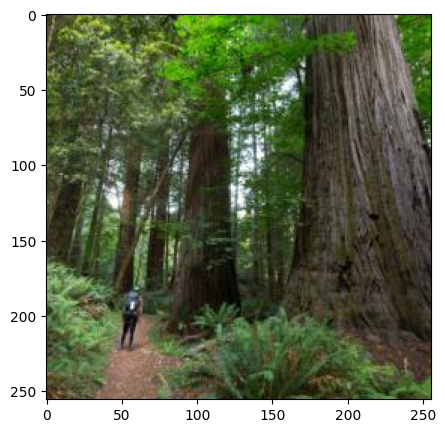

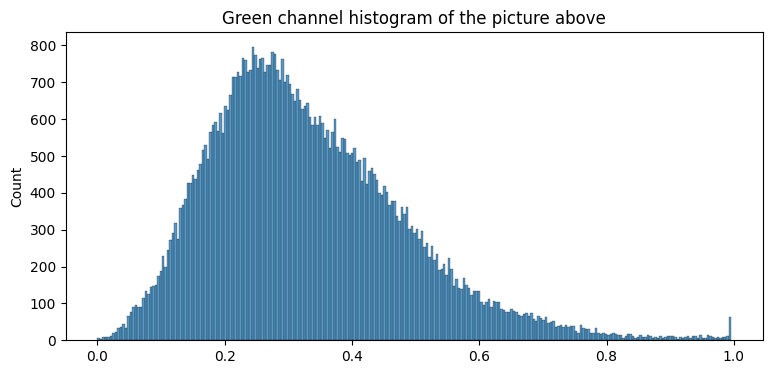

In [14]:
plt.figure(figsize=(5,5))
plt.imshow(img)
plt.figure(figsize=(9,4))
sns.histplot(img[:,:,1].ravel()/256,bins=255)
plt.title("Green channel histogram of the picture above")

In [15]:
print(f"Mean of green channel: {np.mean(img[:,:,0].ravel()/256)}")
print(f"Variance: {np.var(img[:,:,0].ravel()/256)}")
print(f"Skewness: {skew(img[:,:,0].ravel()/256)}")
print(f"Kurtosis: {kurtosis(img[:,:,0].ravel()/256)}")

Mean of green channel: 0.2880939245223999
Variance: 0.018451088742821753
Skewness: 1.195993382296704
Kurtosis: 2.2646503472423625


In [16]:
%%time

# Calculate and append means and variances of each image channels into a dataframe. 
# Also make a list of labels (y) at the same time.

FirstOrderFeatures = pd.DataFrame()
y = pd.DataFrame()

for i, group in enumerate((IMGS_lava,IMGS_ocean,IMGS_trees)):
    print(i)
    for img in group:
        img = img/256 # scale to [0, 1]
        temp_features = []
        for channel in range(3):
            temp_features = temp_features + [np.mean(img[:,:,channel].ravel()),
                                  np.var(img[:,:,channel].ravel()),
                                  skew(img[:,:,channel].ravel()),
                                  kurtosis(img[:,:,channel].ravel())]
            
        FirstOrderFeatures = pd.concat([FirstOrderFeatures, pd.DataFrame(temp_features)], axis=1, ignore_index=True)
        y = pd.concat([y,pd.DataFrame([i])],ignore_index=True)

FirstOrderFeatures = FirstOrderFeatures.T        
# Change the column names
FirstOrderFeatures.columns=['m_red','v_red','s_red','k_red','m_green','v_green','s_green','k_green','m_blue','v_blue','s_blue','k_blue']
y.columns=['label']

0
1
2
CPU times: total: 1.53 s
Wall time: 1.52 s


In [17]:
FirstOrderFeatures

m_red     v_red     s_red     k_red   m_green   v_green   s_green  \
0    0.447511  0.082041  0.756599 -0.788652  0.209575  0.036514  1.645472   
1    0.153800  0.054732  2.057864  3.732913  0.117624  0.009314  1.792527   
2    0.421544  0.153867  0.341759 -1.551643  0.185335  0.062945  1.760005   
3    0.478389  0.108379  0.246486 -1.273808  0.216689  0.067370  1.622715   
4    0.811604  0.019380 -0.304803 -1.220833  0.416121  0.119058  0.718642   
..        ...       ...       ...       ...       ...       ...       ...   
168  0.431971  0.022116  0.297221 -0.351647  0.581401  0.021436 -0.147049   
169  0.380657  0.026719  0.850333  0.792314  0.352656  0.021990  1.241557   
170  0.304011  0.023084  1.097925  1.199172  0.319212  0.031781  0.827113   
171  0.373877  0.030704  0.271531 -0.409144  0.423900  0.042297  0.050763   
172  0.288094  0.018451  1.195993  2.264650  0.328945  0.023324  0.866050   

      k_green    m_blue    v_blue    s_blue     k_blue  
0    2.434172  0.158624  0.014626  1.165607   1.101633  
1    7.517547  0.202389  0.021091  0.016636  -1.172903  
2    2.178377  0.037309  0.007598  7.332614  63.825567  
3    1.675385  0.147568  0.019329  1.651546   3.943201  
4   -1.148549  0.230499  0.054888  1.655226   1.440307  
..        ...       ...       ...       ...        ...  
168 -0.358379  0.422947  0.021100  0.171507  -0.439749  
169  1.856834  0.275930  0.019535  1.373316   2.538435  
170  0.294825  0.258272  0.027025  1.077158   1.465701  
171 -0.966818  0.301795  0.029648  0.908671   0.898402  
172  1.117859  0.206354  0.019445  1.595023   4.497306  

[173 rows x 12 columns]

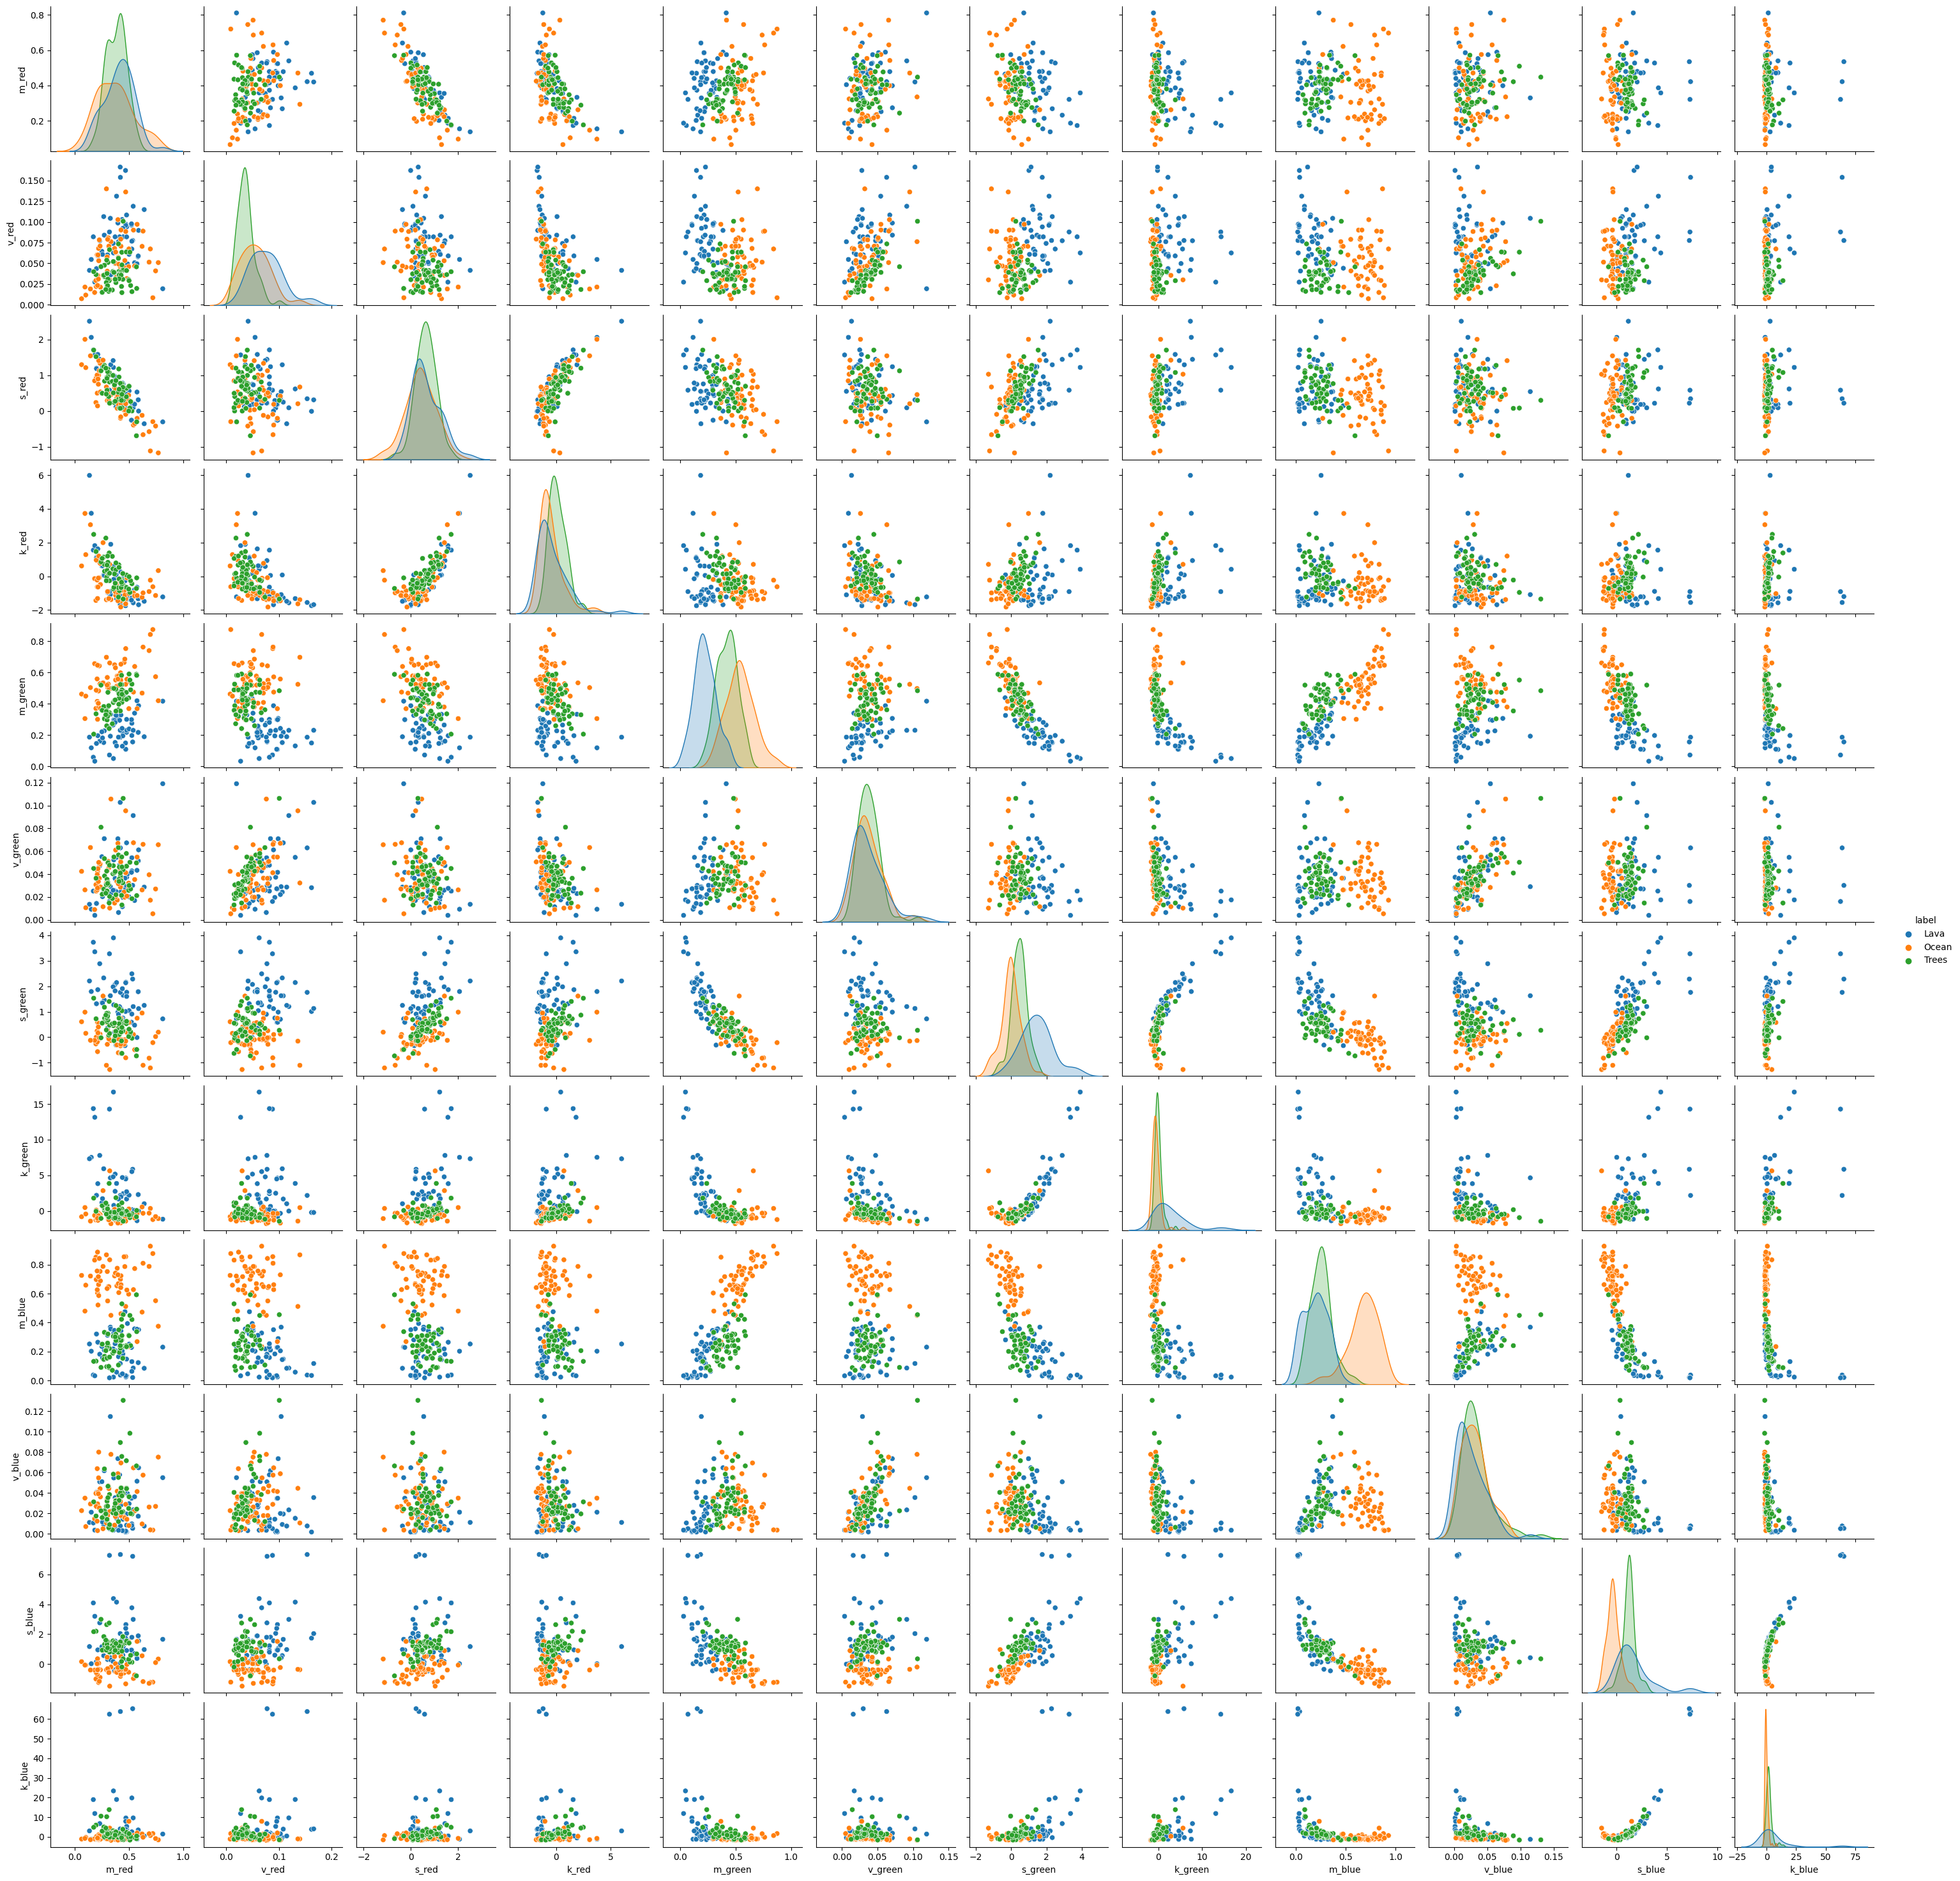

In [168]:
# Combine features and labels (turned to strings) into a dataframe for better visualization
y_s = y.copy()
labels = {0: 'Lava', 1: 'Ocean', 2: 'Trees'} 
y_s.label = [labels[item] for item in y.label] 

Xy = pd.concat([FirstOrderFeatures.reset_index(drop=True), y_s.astype('category').reset_index(drop=True)], axis=1)
sns.pairplot(Xy,hue="label")

We can see some interesting correlations, and that in many pairs the different groups are quite separated. 

There are three lava outliers, especially with the last two columns, which are the skewness and kurtosis of the blue channel. Let's study those further.

In [183]:
FirstOrderFeatures[FirstOrderFeatures.loc[:,'k_blue']>=50]

m_red     v_red     s_red     k_red   m_green   v_green   s_green  \
2   0.421544  0.153867  0.341759 -1.551643  0.185335  0.062945  1.760005   
11  0.534787  0.077601  0.218858 -1.198370  0.155157  0.030139  2.283161   
36  0.320884  0.087921  0.581148 -0.907387  0.071691  0.016077  3.274533   

      k_green    m_blue    v_blue    s_blue     k_blue  
2    2.178377  0.037309  0.007598  7.332614  63.825567  
11   5.846031  0.020409  0.005234  7.211044  65.287381  
36  14.273107  0.018173  0.004987  7.273735  62.458533

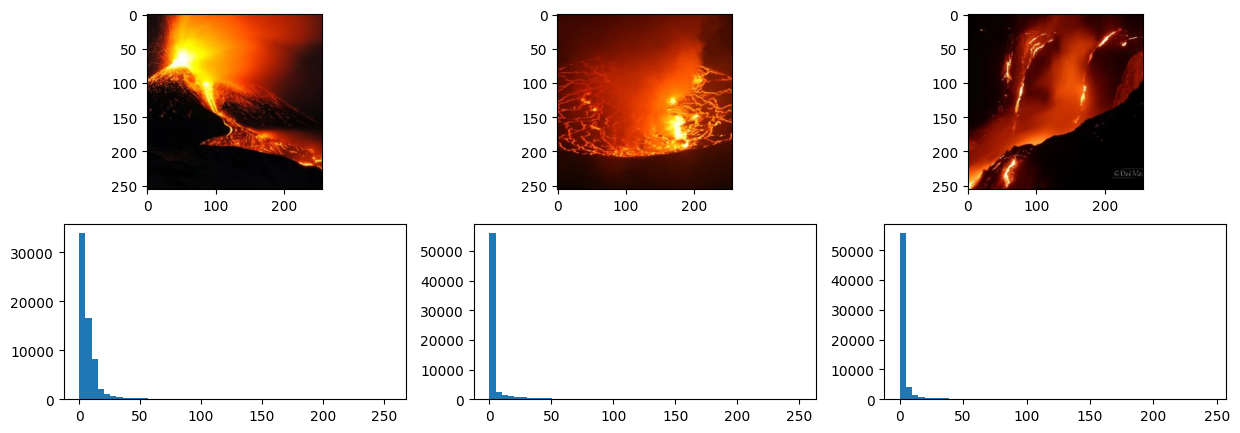

In [194]:
fig, ax = plt.subplots(2,3, figsize=[15,5])
ax[0][0].imshow(IMGS_lava[2-len(IMGS_lava)])
ax[0][1].imshow(IMGS_lava[11-len(IMGS_lava)])
ax[0][2].imshow(IMGS_lava[36-len(IMGS_lava)])
_ = ax[1][0].hist(IMGS_lava[2-len(IMGS_lava)][:,:,2].ravel(),bins=50)
_ = ax[1][1].hist(IMGS_lava[11-len(IMGS_lava)][:,:,2].ravel(),bins=50)
_ = ax[1][2].hist(IMGS_lava[36-len(IMGS_lava)][:,:,2].ravel(),bins=50)

As we can see, the outliers have almost no blue or green color in them. That's why the blue color's histograms are extremely skewed and sharp (have high kurtosis). This is a good recognition pattern to distinguish images of lava, although not all the lava pictures are this extreme.

## Second order features
The second order features describe the relationships between consequitive pixels. For this task, I will use grey-level-co-occurence matrix (GLCM) and grey-level-run-length matrix (GLRLM).

For GLCM let's calculate:
- contrast
- dissimilarity
- homogeneity
- ASM
- correlation

Let's calculate these for two distances and four directions.

For GLRLM let's calculate:
- run percentage
- short run emphasis
- long run emphasis

For horizontal and vertical directions.

Grey-level-co-occurence matrix  describes, from a greyscale image, how many occurances there are of each pixel pairs over certain distances and directions. For example, a GLCM with distance=1 and angle=0 decrees tells us how many occurances of pixels with the same value are within 1 distance of each other (so in this case a pair of pixels with the same value) along the horizontal direction (0 degrees). Distance 2 would mean there is one pixel between the pair, and so on. Since most images are really detailed and the pixel intensities can vary from 0 to 255, GLCM is usually calculated to a quantized version of the image, where for example only 8 different pixel values exist.

Let's first quantize the images. Let's write our own function for this

In [104]:
# A function that turns image into greyscale and quantizes it to quan-number of discrete values
def greyquan(img, quan = 7):
    if img.shape[2]!=3:
        img = img[:,:,:3]
    img_grey = color.rgb2gray(img) 
    min_val = min(img_grey.ravel())
    max_val = max(img_grey.ravel())
    quan_value = (max_val - min_val) / quan # each bin has this range
    less_color = (img_grey // quan_value) # divide and round the image values
    overlap = max(less_color.ravel()) - quan # change values to start from 0
    less_color = less_color - overlap
    return less_color

Text(0.5, 1.0, 'Quantized image')

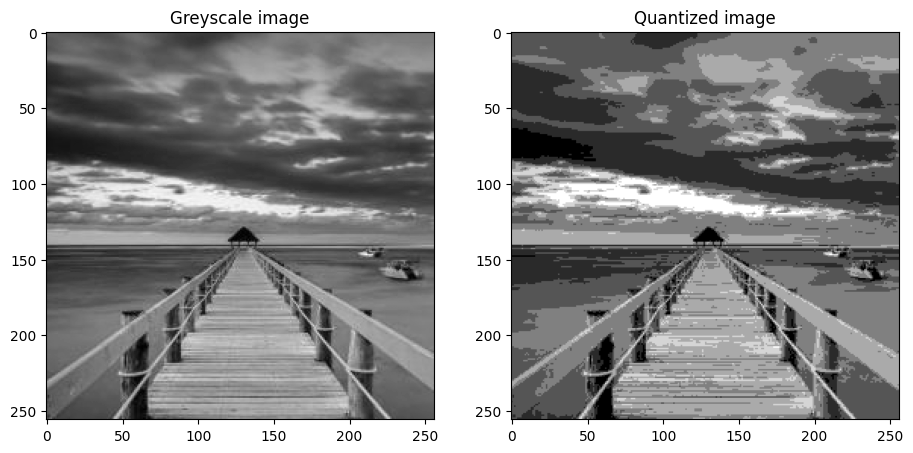

In [65]:
# Display the first image of each category and their dimensions
img = imread(os.path.join(PATH_ocean, os.listdir(PATH_ocean)[0]))
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,6))
ax[0].imshow(color.rgb2gray(img),cmap="gray")
ax[0].set_title("Greyscale image")
ax[1].imshow(greyquan(img),cmap="gray")
ax[1].set_title("Quantized image")

In [70]:
# Let's test and see GLCM in action
test = [[1,1,1,0],
        [2,0,0,1],
        [1,0,2,2],
        [0,0,0,0]]

glcm = graycomatrix(test, distances=[1], angles=[0], levels=3)
pd.DataFrame(glcm.reshape(3,-1))

0  1  2
0  4  1  1
1  2  2  0
2  1  0  1

We can see that the result is 3x3 matrix, since there are 3 unique values in the test matrix. The first value 4 in cell (0,0) tells us that there are 4 occurences of pairs of 0 in the horizontal direction. There are on the second row (1st pair) and the last row (2nd, 3rd and 4th pair). The 1 in cell (0,1) tells us that there is only one 01 pair in the test matrix, at the end of the second row.

### Choosing distances
GLCM takes distances and angles as an input. Angles are usually limited to four directions: horizontal, diagonal, vertical and anti-diagonal. The distances can be anything from 0 to 255. In order to keep the number of features low, let's only choose two features.

We want to choose the features so that they differ as much as possible for each group of images. Let's calculate the correlation of GLCM in both horizontal and vertical directions, and see if there are differences between each image of each group.*

CPU times: total: 19.1 s
Wall time: 19.1 s


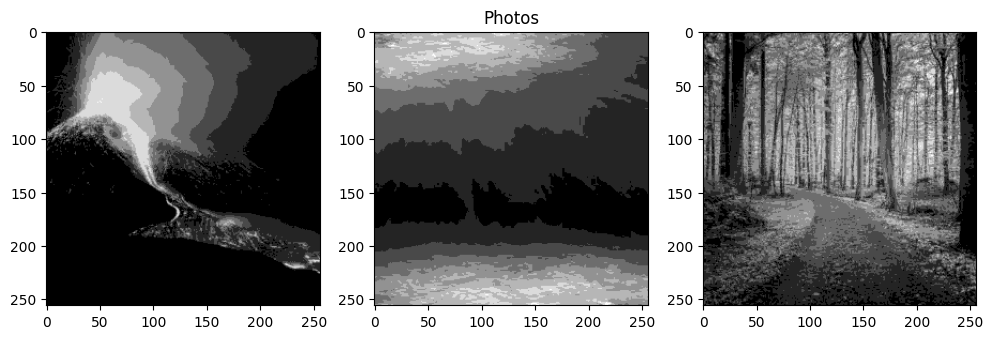

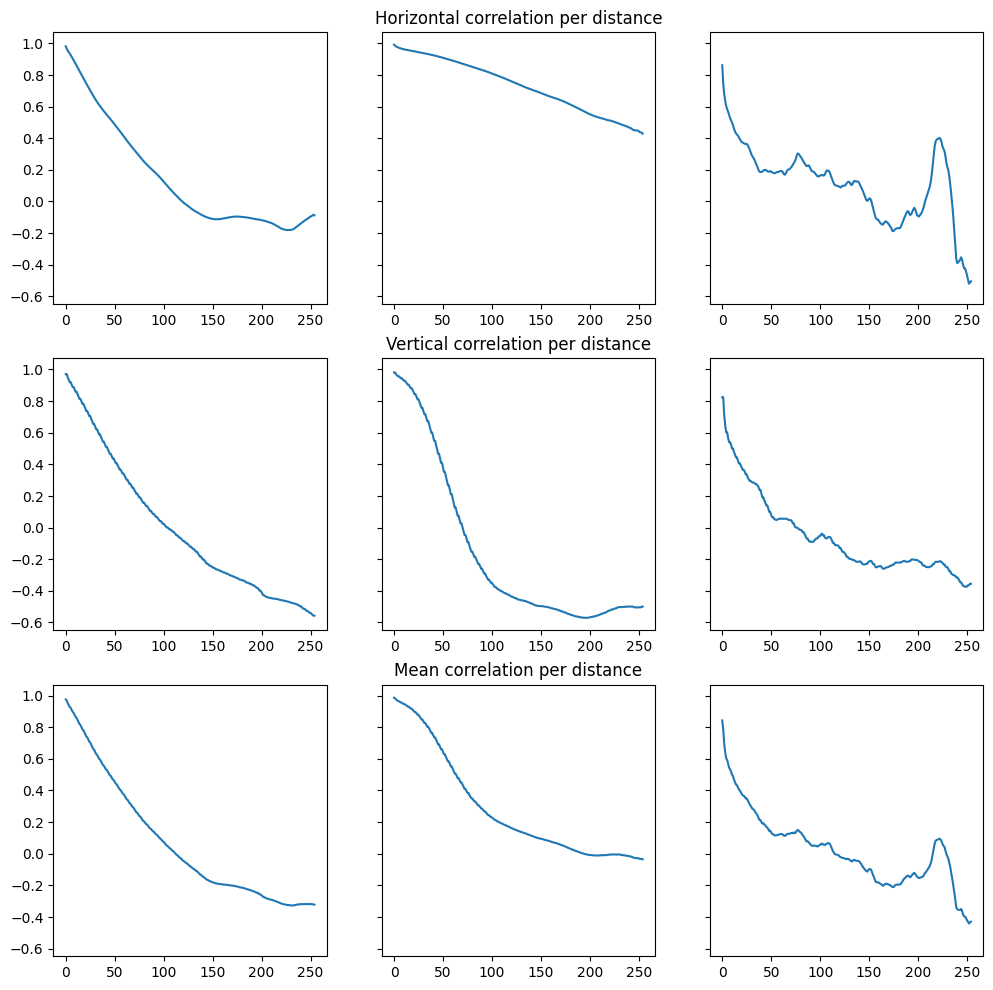

In [74]:
%%time
from warnings import filterwarnings
filterwarnings('ignore')

# Calculate and plot the correlation values for each distance pixel for three photos. 
# Check if there's any interesting distances that would suit for the final features.

fig1, ax1 = plt.subplots(nrows = 1, ncols = 3,figsize = (12, 4))
fig2, ax2 = plt.subplots(nrows = 3, ncols = 3,figsize = (12, 12),sharey=True)
for j,g in zip(range(3), (IMGS_lava, IMGS_ocean, IMGS_trees)):

    corrs_x=[]
    corrs_y=[]
    corrs=[]
    for i in range(1,256):
        img_greyquan = greyquan(g[2])
        
        # Normalize image color values between 0 and 1 for greycomatrix function. 
        # Also change it to ubyte because otherwise there's an error.
        img_greyquan_norm = img_as_ubyte(img_greyquan / 7)
        glcm = graycomatrix(img_greyquan_norm, distances = [i], angles = [0, 3*np.pi/4], symmetric = True, normed = True)
        corr = graycoprops(glcm, 'correlation')
        
        corrs_x.append(corr[0][0])
        corrs_y.append(corr[0][1])
        corrs.append((corr[0][0] + corr[0][1]) / 2)
       
    ax1[j].imshow(img_greyquan,cmap = 'gray')
    ax2[0][j].plot(corrs_x)
    ax2[1][j].plot(corrs_y)
    ax2[2][j].plot(corrs)
    ax1[1].set_title("Photos")
    ax2[0][1].set_title("Horizontal correlation per distance")
    ax2[1][1].set_title("Vertical correlation per distance")
    ax2[2][1].set_title("Mean correlation per distance")

We can easily see that the correlation of lava and ocean-groups is more smooth than the trees. The correlation of oceans stays high on low distances, whereas it drops with lava and trees. Therefore a good value for the first distance could be 20. At the other end, oceans have negative correlation, oceans are at about 0 and trees have a bump in the distances of 220. This is due to there being trees on both sides of the images, which makes the correlation stronger over that distance. That seems like a good second value for distance. 

In [78]:
dists = [20,220]

In [126]:
%%time
from warnings import filterwarnings
filterwarnings('ignore')

GLCM_features = pd.DataFrame() # Dataframe to hold the GLCM features
quan = 7 # Quantization value

# Go through every picture
for group in [IMGS_lava, IMGS_ocean, IMGS_trees]:
    for img in group:
        
        # Greyscaling and quantization, then GLCM and correlation.
        img_greyquan = greyquan(img)
        img_greyquan_norm = img_as_ubyte(img_greyquan / 7)
        glcm = graycomatrix(img_greyquan_norm, distances = dists, angles = [0, 3*np.pi/4], symmetric = True, normed = True)
        
        cont = graycoprops(glcm, 'contrast')
        diss = graycoprops(glcm, 'dissimilarity')
        homo = graycoprops(glcm, 'homogeneity')
        asm = graycoprops(glcm, 'ASM')
        #ener = graycoprops(glcm, 'energy')
        corr = graycoprops(glcm, 'correlation')
        
        GLCM_features = pd.concat([GLCM_features, pd.DataFrame([*cont.ravel(), *diss.ravel(), *homo.ravel(),
                                                              *asm.ravel(),*corr.ravel()])], axis=1, ignore_index=True)
        
GLCM_features.T

CPU times: total: 8.8 s
Wall time: 8.81 s


0            1            2           3          4          5   \
0    3025.207991  3012.743084  4210.959418   6100.2062  32.431574  33.674954   
1    1410.041744  1386.568079   744.459744   1610.0074  16.156912  16.283229   
2    1842.952744  1863.611690  2557.819878   1740.2679  22.163218  22.594717   
3    3143.097938  2388.395636  1115.030056   8568.0248  33.148289  27.882112   
4    3704.355485  5693.143399  9132.997287  16135.7208  35.310199  47.685131   
..           ...          ...          ...         ...        ...        ...   
168  2261.455988  2461.961119  4835.400391   3295.4185  34.984292  37.204136   
169  2347.008590  1974.957670  3433.075955   2347.5714  31.715125  28.997114   
170  2456.809157  2354.933235  3258.991428   2998.7877  35.645789  35.479305   
171  3958.254932  3785.968103  4999.866211   8029.2100  47.716797  46.399768   
172  2311.554903  2350.748890  2783.036133   3407.4313  32.898520  33.583942   

            6        7         8         9         10        11        12  \
0    47.621094  60.5814  0.489126  0.459434  0.255681  0.175743  0.097847   
1    17.032227  36.3420  0.739028  0.731613  0.560754  0.107607  0.279929   
2    28.402995  33.2989  0.615070  0.609497  0.535627  0.280739  0.212544   
3    20.639214  68.1132  0.494721  0.538305  0.518347  0.260453  0.107413   
4    66.534831  96.7500  0.531663  0.446488  0.329420  0.197128  0.096020   
..         ...      ...       ...       ...       ...       ...       ...   
168  54.731554  44.7019  0.330550  0.306432  0.207791  0.249457  0.067683   
169  41.250651  39.5972  0.419983  0.435702  0.331385  0.218328  0.095608   
170  43.354275  40.9577  0.348882  0.334596  0.271513  0.299442  0.072625   
171  56.536784  74.5462  0.253257  0.263525  0.197800  0.129366  0.040776   
172  39.005751  47.0341  0.377242  0.369301  0.313499  0.206374  0.092870   

           13        14        15        16        17        18        19  
0    0.096960  0.074551  0.074801  0.483320  0.499797 -0.108935 -0.103856  
1    0.281660  0.393557  0.303164  0.301584  0.300124 -0.042747 -0.120921  
2    0.200325  0.300161  0.229999  0.767770  0.767547 -0.167761 -0.458114  
3    0.114476  0.227072  0.064796  0.626378  0.719800  0.143872 -0.335486  
4    0.076273  0.085216  0.058894  0.740124  0.588449  0.029309 -0.042410  
..        ...       ...       ...       ...       ...       ...       ...  
168  0.065346  0.052389  0.065248  0.296472  0.233647 -0.226402 -0.047737  
169  0.101257  0.098535  0.120653  0.305492  0.393029  0.060939 -0.177505  
170  0.071892  0.098063  0.109072  0.384091  0.412464 -0.142374 -0.173202  
171  0.041174  0.039152  0.037911  0.261198  0.296397  0.034098 -0.352641  
172  0.092532  0.097401  0.075031  0.221887  0.210099 -0.166896 -0.203644  

[173 rows x 20 columns]

Since the number of features grows quite a lot and we don't need to do further analysis on them, I leave the columns unnamed.

### Grey-level-run-length matrix
Grey-level-run-length matrix calculates how many and how long runs there are of the same pixel value in the image. The matrix will be quite different for a picture of evenly colored ocean and a tree with leaves of varying shades of green (or grey in the greyscale images).

Again we calculate the matrix for quantized images, and for two directions, up and down.

In [133]:
# A function for creating the grey-level-run-length-matrix. Takes image, direction (0=horizontal, 1=vertical) 
# and quantization value as input. Returns a matrix

def GLRLmatrix(image, direction=0, quan=7):

    greys = quan + 1 # Grey level values are quantization level plus one.
    if direction == 1: # For direction down, just transpose the image.
        image = image.T
    d = len(image[0]) # Length of image.
    GLRLM = np.zeros((greys, d)) # Create a numpy matrix (grey levels x number of possible runs).
    
    for row in image: # Go through every row in the image and calculate the run length for each color value in that row.
        j = 0 # number to keep track of the current cell
        
        while j < len(row): # increase j until you've reaced the end of the row
            runlength = 0 # to keep track of the run length
            n = 1 # the next cell
            
            if j < len(row)-1: # If we're not at the last cell, continue, otherwise add 1 to the GLRLM
                while row[j] == row[j+n]: # Count how many next cells are the same
                    runlength += 1 # Increase run length while doing so
                    n += 1
                    
                    if j+n >= len(row): # Just to make sure n doesn't grow past the row length
                        break
                        
            GLRLM[int(row[j])][runlength] += 1 # add 1 to the correct row and column of the GLRLM
            j += n # proceed to the next unchecked cell
            
    return GLRLM

In [134]:
# Run percentage calculates the number of runs per pixel.
def RunP(GLRLM):
    n_r = sum(sum(GLRLM)) # Number of runs, sum of matrix values
    n_p = len(GLRLM[0])**2 # Number of pixels
    RP = n_r / n_p
    return RP

In [135]:
# Short run emphasis returns a higher value if there are many short runs
def Short(GLRLM):
    SRE = 0
    n_r = sum(sum(GLRLM)) # Number of runs, sum of matrix values
    for col,j in zip(GLRLM.T, range(1,len(GLRLM[0])+1)):
        SRE += sum(col/(j**2)) / n_r # Sum up all the columns and divide with (run length)^2. Divide with (# of runs).
    return SRE

In [136]:
# long run emphasis returns a higher value if there are many long runs
def Long(GLRLM):
    LRE=0
    n_r = sum(sum(GLRLM)) # Number of runs, sum of matrix values
    for col,j in zip(GLRLM.T, range(1,len(GLRLM[0])+1)):
        LRE+=sum(col*(j**2)) / n_r # Sum up all the columns and multiply with (run length)^2. Divide with (# of runs).
    return LRE

In [151]:
# Test the grey-level-run-level-matrix
test=[[1,1,1,0],
      [2,0,0,1],
      [1,0,2,2],
      [0,0,0,0]]
GM_hor = GLRLmatrix(np.asarray(test),direction=0,quan=2)
print("0 degrees,  SRE:", round(Short(GM_hor),2), "LRE:", round(Long(GM_hor),2), "RP:", round(RunP(GM_hor),2))
GM_ver = GLRLmatrix(np.asarray(test),direction=1,quan=2)
print("90 degrees, SRE:", round(Short(GM_ver),2), "LRE:", round(Long(GM_ver),2), "RP:", round(RunP(GM_ver),2))
pd.DataFrame(GM_hor,columns=list(range(1,5)))

0 degrees,  SRE: 0.63 LRE: 4.22 RP: 0.56
90 degrees, SRE: 0.94 LRE: 1.57 RP: 0.88


1    2    3    4
0  2.0  1.0  0.0  1.0
1  2.0  0.0  1.0  0.0
2  1.0  1.0  0.0  0.0

Using the same example matrix, the GLRL matrix returns a 4x3 matrix. The values in each cell tell us (how long run, what pixel value). For example, as we can see from the first row, there is a 3-long run of values of 1. This can be seen as a 1 in cell (3,1). From the first column, we can see that there are 2 places with only one run of 0, 2 places with one run of 1's, and 1 place with one run of 2's.

From the short and long run ephases (SRE, LRE) we can see that in the horizontal GLRL matrix there are not many short runs, but quite many long runs.

Let's calculate these values for all the images.

In [153]:
%%time
from warnings import filterwarnings
filterwarnings('ignore')

GLRL_features = pd.DataFrame() # Dataframe to hold the GLCM features
quan = 7 # Quantization value

# Go through every picture
for group in [IMGS_lava, IMGS_ocean, IMGS_trees]:
    for img in group:
        
        # Greyscaling and quantization, then GLCM and correlation.
        img_greyquan = greyquan(img)
        # GLRLM and features from it in vertical and horizontal direction.
        
        GM_H = GLRLmatrix(img_greyquan, direction = 0)
        RP_H = RunP(GM_H)
        SR_H = Short(GM_H)
        LR_H = Long(GM_H)
        
        GM_V = GLRLmatrix(img_greyquan, direction = 1)
        RP_V = RunP(GM_V)
        SR_V = Short(GM_V)
        LR_V = Long(GM_V)
        
        GLRL_features = pd.concat([GLRL_features, pd.DataFrame([RP_H,SR_H,LR_H,RP_V,SR_V,LR_V])],
                                   axis=1, ignore_index=True)
        
GLRL_features.T

CPU times: total: 10.8 s
Wall time: 10.8 s


0         1            2         3         4            5
0    0.134766  0.370905   240.545290  0.137894  0.361897   223.878278
1    0.060532  0.414157  1497.844719  0.061646  0.333411  1589.406931
2    0.088562  0.416213   932.025155  0.090134  0.435738   689.129169
3    0.142181  0.446332   242.440223  0.131256  0.432349   330.451988
4    0.194672  0.518364   253.955479  0.256744  0.580038    93.962439
..        ...       ...          ...       ...       ...          ...
168  0.361938  0.489502    14.861973  0.422684  0.547123    10.406556
169  0.248718  0.425374    45.074479  0.179565  0.365541   117.195105
170  0.385239  0.542467    15.418545  0.288208  0.481681    41.527848
171  0.444885  0.579519    10.197764  0.355881  0.517866    24.308108
172  0.325378  0.482244    21.534796  0.282669  0.451354    33.666721

[173 rows x 6 columns]

In [195]:
# Combine first and second order features and standardize the data
data_all = pd.concat([FirstOrderFeatures,GLCM_features.T,GLRL_features.T],axis=1,ignore_index=True)
X = data_all.apply(zscore)
X

0         1         2         3         4         5         6   \
0    0.439159  0.852825  0.345170 -0.498337 -1.132281 -0.058413  1.135577   
1   -1.724377 -0.033617  2.628164  3.447153 -1.684545 -1.444096  1.299174   
2    0.247875  3.184239 -0.382643 -1.164119 -1.277869  1.288117  1.262994   
3    0.666609  1.707740 -0.549794 -0.921682 -1.089553  1.513559  1.110260   
4    3.121139 -1.181112 -1.516999 -0.875456  0.108249  4.146788  0.104483   
..        ...       ...       ...       ...       ...       ...       ...   
168  0.324685 -1.092317 -0.460783 -0.117010  1.100933 -0.826555 -0.858595   
169 -0.053304 -0.942892  0.509621  0.881204 -0.272931 -0.798353  0.686223   
170 -0.617892 -1.060884  0.944007  1.236225 -0.473793 -0.299550  0.225156   
171 -0.103249 -0.813540 -0.505855 -0.167181  0.154967  0.236199 -0.638529   
172 -0.735141 -1.211262  1.116062  2.165956 -0.415337 -0.730377  0.268473   

           7         8         9   ...        28        29        30  \
0    0.598469 -0.870688 -0.722001  ... -0.253085  0.157131 -0.828029   
1    2.378231 -0.693679 -0.428358  ... -0.912249 -0.656417 -0.654753   
2    0.508912 -1.361349 -1.041236  ...  0.778627  1.248052 -0.982029   
3    0.332807 -0.915404 -0.508379  ...  0.265794  1.053510 -0.166200   
4   -0.655893 -0.579989  1.106744  ...  0.678354  0.518334 -0.466115   
..        ...       ...       ...  ...       ...       ...       ...   
168 -0.379243  0.198372 -0.427934  ... -0.930790 -0.927269 -1.135547   
169  0.396335 -0.396243 -0.499043  ... -0.898072 -0.277883 -0.383311   
170 -0.150547 -0.467659 -0.158839  ... -0.612992 -0.198700 -0.915569   
171 -0.592266 -0.291630 -0.039708  ... -1.058730 -0.671602 -0.453580   
172  0.137609 -0.677645 -0.503122  ... -1.201312 -1.023215 -0.979766   

           31        32        33        34        35        36        37  
0    0.592430 -0.618605 -0.291364 -0.310958 -1.112514 -1.220819  0.529885  
1    0.534499 -1.131596  0.003332  1.141215 -1.769703 -1.513697  7.765880  
2   -0.610176 -0.937893  0.017342  0.487697 -1.524161 -0.461603  2.995269  
3   -0.193889 -0.567358  0.222556 -0.308770 -1.169723 -0.496456  1.094624  
4    0.801020 -0.204627  0.713348 -0.295470 -0.088130  1.022035 -0.158545  
..        ...       ...       ...       ...       ...       ...       ...  
168  0.782938  0.951265  0.516698 -0.571621  1.342114  0.683619 -0.601311  
169  0.342413  0.168861  0.079760 -0.536726 -0.753341 -1.183347 -0.035434  
170  0.357019  1.112280  0.877574 -0.570979  0.183058  0.010769 -0.436398  
171 -0.252126  1.524465  1.130029 -0.577009  0.766334  0.382807 -0.527646  
172  0.253677  0.698618  0.467247 -0.563914  0.135317 -0.301051 -0.478054  

[173 rows x 38 columns]

## Predictions
Let's use LightGBM classifier to classify the images. Lets use KFolds with suffle=True, since our images are currently in order.

In [247]:
%%time
training_scores=[]
testing_scores=[]
model_LGBM = lgb.LGBMClassifier(random_state=42,verbose=-1)

kf = KFold(n_splits=5, random_state=42, shuffle=True)

for train_index, test_index in kf.split(X):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    model_LGBM.fit(X_train,y_train)
    pred_y = model_LGBM.predict(X_test)
    training_scores.append(model_LGBM.score(X_train, y_train))
    testing_scores.append(model_LGBM.score(X_test, y_test))
    
print('Training set score: {:.4f}'.format(np.mean(training_scores)))
print('Test set score: \033[1m {:.4f}\033[0m'.format(np.mean(testing_scores)))

Training set score: 1.0000
Test set score:  0.9136
CPU times: total: 3.45 s
Wall time: 454 ms


91.4% test set accuracy. LightGBM is also really fast, but on the other hand this is really small dataset.

Lets do grid search for better parameters.

In [240]:
%%time
from sklearn.model_selection import  GridSearchCV

gridParams = {
    'learning_rate': [0.005, 0.01,0.1],
    'n_estimators': [8,16,24,100],
    'num_leaves': [2,4,6,8,10,31], 
    }

clf = GridSearchCV(model_LGBM, gridParams, n_jobs=-1, verbose=1, cv=5)
clf.fit(X,y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
CPU times: total: 15.6 s
Wall time: 14.4 s


GridSearchCV(cv=5,
             estimator=LGBMClassifier(learning_rate=0.01, num_leaves=4,
                                      random_state=42, verbose=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.005, 0.01, 0.1],
                         'n_estimators': [8, 16, 24, 100],
                         'num_leaves': [2, 4, 6, 8, 10, 31]},
             verbose=1)

In [248]:
clf.best_estimator_

LGBMClassifier(num_leaves=4, random_state=42, verbose=-1)

Since our dataset is so small, instead of 5 folds we can do Leave-one-out (LOO), where we do N folds, where N is the size of the data. In other words, we do 172 rounds, and on each round we take one image away, train the model with all but one image, and then test whether it can correctly label the missing image. We do this to all the images, which shouldn't take too long. This provides a highly accurate measures for the model accuracy, but is not feasible if the amount of data becomes too big.

In [253]:
%%time

y_preds_lgbm=[]
loo = LeaveOneOut()
r=len(X)
model_LGBM = clf.best_estimator_

print("Splits left: ",end = '')
for train_index, test_index in loo.split(X):
    r-=1
    print(r, end = ', ')
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    model_LGBM.fit(X_train,y_train)
    
    y_preds_lgbm.append(model_LGBM.predict(X_test)[0])

Splits left: 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, CPU times: total: 1min 10s
Wall time: 9.2 s


In [254]:
print('Accuracy: \033[1m {:.4f}\033[0m'.format(accuracy_score(y,y_preds_lgbm)))
    
cm = pd.DataFrame(confusion_matrix(y, y_preds_lgbm),
                  index=['True lava','True ocean','True trees'],
                  columns=['Pred lava','Pred ocean','Pred trees'])
cm

Accuracy:  0.9306


Pred lava  Pred ocean  Pred trees
True lava          48           0           8
True ocean          2          55           0
True trees          2           0          58

The final accuracy of the tuned model, validated with LOO, is 93%. From the confusion matrix we can see that all the ocean images were correctly labeled, and predictions of lava images were almost all correct except 2 oceans and 2 trees. The biggest error comes from 8 lava images that were incorrectly labeled as trees, but 93% is still quite good accuracy from simple conventional texture features.